# figures_draft2017a.ipynb

## Purpose
Produce figures and supplementary figures for *"Radiative effects of anthropogenic aerosol emissions from different source regions"*.

## Additional supplementary figures
Some additional supplementary figures are produced by [emissions_bug_draft2017a.ipynb](https://github.com/grandey/draft2017a-region-rfp/blob/master/emissions_bug_draft2017a.ipynb).

## Dependencies
Python modules mentioned in next cell, inlcuding [climapy](https://github.com/grandey/climapy) ([doi:10.5281/zenodo.1053020](https://doi.org/10.5281/zenodo.1053020)) and [lib_draft2017a.py](https://github.com/grandey/draft2017a-region-rfp/blob/master/lib_draft2017a.py) 

## Data requirements
CESM output data, post-processed to time-series format, as described in [data_management.org](https://github.com/grandey/draft2017a-region-rfp/blob/master/data_management.org#syncing-to-local-machine-for-analysis). These data will also be uploaded to figshare.

## Author
Benjamin S. Grandey, 2017-2018

In [1]:
! date

Mon Apr 30 12:12:47 +08 2018


In [2]:
import climapy
import lib_draft2017a
import ipywidgets
from IPython.display import display
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import os
import pandas as pd
from scipy import stats
import xarray as xr

# Print versions of dependencies
for package in [climapy, np, pd, xr]:
    try:
        print('{}.__version__ = {}'.format(package.__name__, package.__version__))
    except AttributeError:
        pass
print('lib_draft2017a.py is using {}'.format(lib_draft2017a.dependency_versions()))

climapy.__version__ = 0.1.0+b35937c
numpy.__version__ = 1.14.3
pandas.__version__ = 0.22.0
xarray.__version__ = 0.10.3
lib_draft2017a.py is using {'climapy': '0.1.0+b35937c', 'numpy': '1.14.3', 'pandas': '0.22.0', 'xarray': '0.10.3'}


In [3]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 40  # reduce resolution of inline figures
plt.rcParams['axes.titlepad'] = 15  # increase distance to title

In [4]:
# Load dictionaries etc from lib_draft2017a
region_bounds_dict = lib_draft2017a.load_region_bounds_dict()
region_long_dict = lib_draft2017a.load_region_long_dict()
scenario_name_dict = lib_draft2017a.load_scenario_name_dict()
variable_long_dict = lib_draft2017a.load_variable_long_dict()
variable_symbol_dict = lib_draft2017a.load_variable_symbol_dict()
variable_units_dict = lib_draft2017a.load_variable_units_dict()

In [5]:
# Initialise counters to keep track of figure numbers
figure_counter = 1  # main manuscript
supp_figure_counter = 1  # supplementary figures
other_figure_counter = 1  # other figures (not included in manuscript)

In [6]:
# Control whether supplementary and other figures get produced
produce_supp = False
produce_other = False

# 1. Regions
One figure in main manuscript.

## Map of regions

Written local/f01.pdf


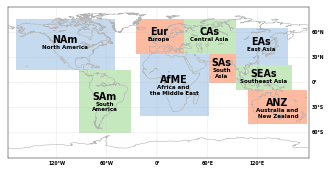

In [7]:
# Load sample data
sample_data = lib_draft2017a.load_output('BURDENSO4', scenario='p16a_F_Hist_2000',
                                         season='annual').isel(year=0).copy()
# Set sample data equal to one - here, we are just interested in lat-lon info
sample_data[:] = 1.
# Shift longitudes
sample_data = climapy.xr_shift_lon(sample_data, lon_min=-179)
# Longitude and latitude data
lon = sample_data['lon']
lat = sample_data['lat']
# Lower bound for first longitude bin (important for map)
lon0 = (lon[0] - (lon[1]-lon[0])/2.0).values
# Pseudo-lower bound for first latitude bin (used for stretching imshow)
lat0 = (lat[0] - (lat[1]-lat[0])/2.0).values
# Set-up plot
fig = plt.figure(figsize=(8.0, 6.0))
bm = Basemap(llcrnrlat=-90.0, urcrnrlat=90.0, llcrnrlon=lon0, urcrnrlon=lon0+360.0)
bm.drawcoastlines(color='0.7')
bm.drawparallels([-60, -30, 0, 30, 60], labels=[0, 1, 0, 0], fontsize='small',
                  fontweight='bold', color='0.7', linewidth=0.5)
bm.drawmeridians([-120, -60, 0, 60, 120], labels=[0, 0, 0, 1], fontsize='small',
                  fontweight='bold', color='0.7', linewidth=0.5)
# Plot region masks and names
for region, region_bounds in region_bounds_dict.items():
    lon_bounds, lat_bounds = region_bounds
    # Get long name of region
    long_name = region_long_dict[region]
    if region in ['SAm', 'SAs']:  # split long name over two lines if necessary
        long_name = '\n'.join(long_name.split(' '))
    if region in ['AfME', 'ANZ']:
        long_name = 'and\n'.join(long_name.split('and'))
    # Set colour map
    if region in ['NAm', 'AfME', 'EAs']:  # shading colour dependent on region
        cmap = 'Blues'
    elif region in ['SAm', 'CAs', 'SEAs']:
        cmap = 'Greens'
    else:
        cmap = 'Reds'
    # Create data for region using sample_data
    region_data = sample_data.copy()
    region_data = climapy.xr_mask_bounds(region_data, select_how='inside',  # mask
                                         lon_bounds=lon_bounds, lat_bounds=lat_bounds)
    # Plot data and annotations
    if lon_bounds is not None:
        plt.imshow(region_data, extent=[lon0, 360+lon0, -lat0, lat0],
                   interpolation='Nearest', cmap=cmap,
                   vmin=0, vmax=4)
        label_pos = [(lon_bounds[0]+lon_bounds[1])/2,
                     (lat_bounds[0]+lat_bounds[1])/2]
        plt.text(label_pos[0], label_pos[1], region,  # short name
                 color='k', weight='bold', fontsize='xx-large',
                 horizontalalignment='center', verticalalignment='bottom')
        plt.text(label_pos[0], label_pos[1], long_name,  # long name
                 color='k', weight='bold',
                 horizontalalignment='center', verticalalignment='top')
# Save figure
fig.tight_layout()
plt.savefig('local/f{:02}.pdf'.format(figure_counter), bbox_inches='tight', dpi=300)
print('Written local/f{:02}.pdf'.format(figure_counter))
figure_counter += 1

# 2. Emissions
Three supplementary figures.

## Load global emissions data

In [8]:
# Load global emissions for different scenarios into dataframe
global_emissions_df = pd.DataFrame(columns=('scenario', 'scenario_name',
                                            'species', 'global_total'))
# Loop over scenarios and variables
for scenario, scenario_name in scenario_name_dict.items():
    # Load emissions for organic carbon (g/m2/yr)
    oc_both = lib_draft2017a.load_emissions('oc', 'both', scenario=scenario[7:])
    # Load emissions for black carbon (g/m2/yr)
    bc_both = lib_draft2017a.load_emissions('bc', 'both', scenario=scenario[7:])
    # Load emissions for sulfur species (g(S)/m2/yr)
    so2_both = lib_draft2017a.load_emissions('so2', 'both', scenario=scenario[7:])
    so4_a1_surf = lib_draft2017a.load_emissions('so4_a1', 'surf', scenario=scenario[7:])
    so4_a1_elev = lib_draft2017a.load_emissions('so4_a1', 'elev', scenario=scenario[7:])
    if scenario[0:6] == 'p17b_F':  # intended so4_a2 emissions
        so4_a2_surf = lib_draft2017a.load_emissions('so4_a2', 'surf', scenario=scenario[7:])
    else:  # due to bug
        so4_a2_surf = lib_draft2017a.load_emissions('so4_a1', 'surf', scenario=scenario[7:])
    so4_a2_elev = lib_draft2017a.load_emissions('so4_a2', 'elev', scenario=scenario[7:])
    dms = lib_draft2017a.load_emissions('dms', 'both')
    # Sum emissions for sulfur species
    s_both = so2_both + so4_a1_surf + so4_a1_elev + so4_a2_surf + so4_a2_elev + dms
    # Calculate global totals (Tg/yr)
    s_global = climapy.xr_area_weighted_stat(s_both, stat='sum').values / 1e12
    oc_global = climapy.xr_area_weighted_stat(oc_both, stat='sum').values / 1e12
    bc_global = climapy.xr_area_weighted_stat(bc_both, stat='sum').values / 1e12
    # Store global totals in dataframe
    for species, global_total in zip(['S', 'OC', 'BC'], [s_global, oc_global, bc_global]):
        global_emissions_df = global_emissions_df.append({'scenario': scenario, 
                                                          'scenario_name': scenario_name,
                                                          'species': species,
                                                          'global_total': global_total},
                                                         ignore_index=True)
    # Close data arrays
    for da in [oc_both, bc_both, so2_both, so4_a1_surf, so4_a1_elev,
               so4_a2_surf, so4_a2_elev, dms]:
        da.close()

global_emissions_df.head()

,scenario,scenario_name,species,global_total
0,p16a_F_Hist_2000,All1,S,84.596255
1,p16a_F_Hist_2000,All1,OC,35.889499
2,p16a_F_Hist_2000,All1,BC,7.758681
3,p16a_F_Zero_2000,All0,S,32.718225
4,p16a_F_Zero_2000,All0,OC,23.188555


In [9]:
# Print emissions for All0
global_emissions_df[(global_emissions_df['scenario_name'] == 'All0')]

,scenario,scenario_name,species,global_total
3,p16a_F_Zero_2000,All0,S,32.718225
4,p16a_F_Zero_2000,All0,OC,23.188555
5,p16a_F_Zero_2000,All0,BC,2.608787


In [10]:
# For emissions, calculate differences from reference scenarios
def diff_according_to_scenario_name_for_emissions(row):
    """
    For emissions, calculate difference according to scenario name.
    
    Args:
        row: row of the global_emissions_df DataFrame.
    
    Returns:
        Modified version of row containing 'scenario_diff' and 'global_diff'.
    """
    scenario_name = row['scenario_name']
    if scenario_name[-1] == '1':  # if ends with '1', compare to All0
        ref_name = 'All0'
    else:  # if ends with '0', compare to All1
        ref_name = 'All1'
    ref_row = global_emissions_df[(global_emissions_df['species'] == row['species']) &
                                  (global_emissions_df['scenario_name'] == ref_name)
                                 ].T.squeeze()  # DataFrame to Series
    if ref_name == 'All0':
        scenario_diff = '{}-All0'.format(scenario_name)
        global_diff = row['global_total'] - ref_row['global_total']
    else:
        scenario_diff = 'All1-{}'.format(scenario_name)
        global_diff = ref_row['global_total'] - row['global_total']
    row['ref_name'] = ref_name
    row['scenario_diff'] = scenario_diff
    row['global_diff'] = global_diff
    return row

diff_emissions_df = global_emissions_df.apply(diff_according_to_scenario_name_for_emissions,
                                              axis=1)  # apply function above
diff_emissions_df.head()

,scenario,scenario_name,species,global_total,ref_name,scenario_diff,global_diff
0,p16a_F_Hist_2000,All1,S,84.596255,All0,All1-All0,51.878029
1,p16a_F_Hist_2000,All1,OC,35.889499,All0,All1-All0,12.700944
2,p16a_F_Hist_2000,All1,BC,7.758681,All0,All1-All0,5.149895
3,p16a_F_Zero_2000,All0,S,32.718225,All1,All1-All0,51.878029
4,p16a_F_Zero_2000,All0,OC,23.188555,All1,All1-All0,12.700944


## Emissions barcharts

In [11]:
# Function to produce staggered barcharts for a given emissions species
def emissions_staggered_barcharts(species='S', title='Sulfur emissions',
                                  ylabel=r'$\Delta$ global sulfur emissions, Tg(S) yr$^{-1}$',
                                  text_format=r' {:+.1f}', baseline_text_format='{:.1f}',
                                  map_insert=True, ylim=None,
                                  n_contributors='auto',
                                  file_prefix=None):
    # Set up plot
    fig, ax = plt.subplots(figsize=(12, 7))
    # Get subset of relevant data from diff_emissions_df
    bars_df = diff_emissions_df[(diff_emissions_df['species'] == species)]
    # Delete repeat of All1-All0
    bars_df = bars_df[(bars_df['scenario_name'] != 'All0') | (bars_df['ref_name'] != 'All1')]
    # Set scenario_diff as index, after changing dtype to object (to facilitate easier appending)
    bars_df['scenario_diff'] = bars_df['scenario_diff'].astype('object')
    bars_df = bars_df.set_index('scenario_diff')
    # Add 'bottom' column and 'x' position column, both initialised as NaNs
    bars_df = bars_df.assign(bottom=np.nan, x=np.nan)
    # x position and bottom for first two bars
    bars_df.loc['Correct1-All0', 'x'] = 0  # 1st bar
    bars_df.loc['Correct1-All0', 'bottom'] = 0
    bars_df.loc['All1-All0', 'x'] = 3  # 2nd bar
    bars_df.loc['All1-All0', 'bottom'] = 0
    # 1st set of staggered bars
    order1 = (bars_df[(bars_df['ref_name'] == 'All0') &  # order <Source>1-All0 by global_diff
                      (bars_df['scenario_name'] != 'All1') &
                      (bars_df['scenario_name'] != 'Correct1')].
              sort_values(by='global_diff', ascending=False).index)
    bars_df.loc[order1, 'x'] = np.arange(len(order1)) + max(bars_df['x']) + 3
    for i in (range(len(order1))):
        if i == 0:
            bars_df.loc[order1[i], 'bottom'] = 0
        else:
            bars_df.loc[order1[i], 'bottom'] = (bars_df.loc[order1[i-1], 'bottom'] +
                                                bars_df.loc[order1[i-1], 'global_diff'])
    # 1st combined bar
    global_diff = bars_df.loc[order1, 'global_diff'].sum()
    bars_df = bars_df.append(pd.Series({'global_diff': global_diff,
                                        'x': max(bars_df['x'])+3, 'bottom': 0},
                                       name=r'$\Sigma_{\Theta}$($\Theta$1-All0)'))
    # 2nd set of staggered bars
    order2 = (bars_df[(bars_df['ref_name'] == 'All1') &  # order All1-<Source>0 by global_diff
                      (bars_df['scenario_name'] != 'All0')].
              sort_values(by='global_diff', ascending=False).index)
    bars_df.loc[order2, 'x'] = np.arange(len(order2)) + max(bars_df['x']) + 3
    for i in (range(len(order2))):
        if i == 0:
            bars_df.loc[order2[i], 'bottom'] = 0
        else:
            bars_df.loc[order2[i], 'bottom'] = (bars_df.loc[order2[i-1], 'bottom'] +
                                                bars_df.loc[order2[i-1], 'global_diff'])
    # 2nd combined bar
    global_diff = bars_df.loc[order2, 'global_diff'].sum()
    bars_df = bars_df.append(pd.Series({'global_diff': global_diff,
                                        'x': max(bars_df['x'])+3, 'bottom': 0},
                                       name=r'$\Sigma_{\Theta}$(All1-$\Theta$0)'))
    # Add colour based on whether -ve or +ve
    bars_df = bars_df.assign(color='salmon')  # all bars are +ve
    # Plot barchart
    ax.bar(bars_df['x'], bars_df['global_diff'], bottom=bars_df['bottom'],
           width=1., color=bars_df['color'])
    # Axes and title
    plt.axhline(y=0, linewidth=0.5, color='k', alpha=0.5)
    ax.set_xticks(bars_df['x'])
    ax.set_xticklabels(bars_df.index, rotation=90)
    ax.set_xlabel('Scenario combination', fontsize='x-large')
    ax.set_ylabel(ylabel, fontsize='x-large')
    if ylim:
        ax.set_ylim(ylim)
    else:  # stretch y-axis to accommodate annotations
        ax.set_ylim([y * 1.15 for y in ax.get_ylim()])
    ax.set_title(title, fontsize='xx-large')
    # Annotate with values
    for scenario in bars_df.index:
        text = text_format.format(bars_df.loc[scenario, 'global_diff'])
        if bars_df.loc[scenario, 'global_diff'] > 0:
            verticalalignment='bottom'
        else:
            verticalalignment='top'
        ax.text(bars_df.loc[scenario, 'x'], bars_df.loc[scenario, ['bottom', 'global_diff']].sum(),
                text, rotation=90, verticalalignment=verticalalignment,
                horizontalalignment='center', fontsize='small')
    # Annotate combined bars with largest contributing sources
    for scenario, order, ref_name in zip([r'$\Sigma_{\Theta}$($\Theta$1-All0)',
                                          r'$\Sigma_{\Theta}$(All1-$\Theta$0)'],
                                         [order1, order2], ['All0', 'All1']):
        if n_contributors == 'auto':
            n = 0  
            perc_sum = 0  # % contribution accounted for so far
            for s in order:
                perc_sum += bars_df.loc[s, 'global_diff'] / bars_df.loc[scenario, 'global_diff'] * 100
                if perc_sum > 100 or perc_sum < 0:
                    break
                elif perc_sum > 80:
                    n += 1
                    break
                else:
                    n += 1
        else:
            n = n_contributors
        for s in order[0:n]:
            y_pos = bars_df.loc[s, ['global_diff', 'bottom']].sum()
            ax.plot([bars_df.loc[s, 'x']+0.5, bars_df.loc[scenario, 'x']+0.5],  # draw horizontal line
                    [y_pos, y_pos], color='darkgreen', linestyle='--', linewidth=0.5)
            perc = bars_df.loc[s, 'global_diff'] / bars_df.loc[scenario, 'global_diff'] * 100  # % contribution
            if ref_name == 'All1':
                source = s.split('-')[1][:-1]
            else:
                source = s.split('-')[0][:-1]
            text = '{}: {:.1f}%'.format(source, perc)
            text_y_pos = bars_df.loc[s, 'bottom'] + (bars_df.loc[s, 'global_diff'] / 2)
            ax.text(bars_df.loc[s, 'x']+0.6, text_y_pos, text,
                    verticalalignment='center', horizontalalignment='left',
                    color='darkgreen', fontsize='small')
    # Annotate with All0 baseline
    all0_baseline = global_emissions_df[(global_emissions_df['scenario_name'] == 'All0') &
                                        (global_emissions_df['species'] == species)
                                       ]['global_total']
    ax.text(-3, 0, ('\n\nBaseline (All0)\nemissions are\n' +
                    baseline_text_format.format(float(all0_baseline)) +
                    'Tg yr$^{-1}$'),
            fontsize='small',
            horizontalalignment='center', verticalalignment='top')
    # Insert map
    if map_insert:
        ax2 = plt.axes([0.125, 0.76, .12, .12], facecolor='lightsteelblue')
        anchor = 'NW'
        lon_bounds = [lon0, lon0+360.]
        lat_bounds = [-90.0, 90.0]
        bm = Basemap(llcrnrlat=lat_bounds[0], urcrnrlat=lat_bounds[1],
                     llcrnrlon=lon_bounds[0], urcrnrlon=lon_bounds[1],
                     anchor=anchor)
        bm.drawcoastlines(color='0.5')
        bm.fillcontinents(color='white')
    # Save figure?
    if file_prefix:
        fig.savefig('local/{}.pdf'.format(file_prefix), bbox_inches='tight', dpi=300)
        print('Written local/{}.pdf'.format(file_prefix))
    # Print percentage contributions from all source regions
    for s in order1:
        source = s.split('-')[0][:-1]
        perc1 = (bars_df.loc[s, 'global_diff'] /  # Theta1-All0 approach
                 bars_df.loc[r'$\Sigma_{\Theta}$($\Theta$1-All0)',
                             'global_diff'] * 100)
        perc2 = (bars_df.loc['All1-{}0'.format(source),  # All1-Theta0 approach
                             'global_diff'] /
                 bars_df.loc[r'$\Sigma_{\Theta}$(All1-$\Theta$0)',
                             'global_diff'] * 100)
        print('{:.0f}%, {:.0f}% from {}'.format(perc1, perc2, source))
    return fig, ax

# Example
if False:
    fig, ax = emissions_staggered_barcharts()

In [12]:
# Global sulfur emissions - supp figure
if produce_supp:
    emissions_staggered_barcharts(species='S',
                                  title='Sulfur emissions over globe',
                                  ylabel=r'$\Delta$ sulfur emissions, Tg(S) yr$^{-1}$',
                                  text_format=r' {:+.1f}', baseline_text_format='{:.1f}',
                                  ylim=[0, 67], n_contributors=7,
                                  file_prefix='fS{:02}'.format(supp_figure_counter))
    supp_figure_counter += 1

In [13]:
# Global organic carbon aerosol emissions - supp figure
if produce_supp:
    emissions_staggered_barcharts(species='OC',
                                  title='Organic carbon aerosol emissions over globe',
                                  ylabel=(r'$\Delta$ organic carbon aerosol '
                                          'emissions, Tg(C) yr$^{-1}$'),
                                  text_format=r' {:+.1f}', baseline_text_format='{:.1f}',
                                  ylim=[0, 16.5], n_contributors=8,
                                  file_prefix='fS{:02}'.format(supp_figure_counter))
    supp_figure_counter += 1

In [14]:
# Global black carbon aerosol emissions - supp figure
if produce_supp:
    emissions_staggered_barcharts(species='BC', title='Black carbon aerosol emissions over globe',
                                  ylabel=(r'$\Delta$ black carbon aerosol '
                                          'emissions, Tg(C) yr$^{-1}$'),
                                  text_format=r' {:+.2f}', baseline_text_format='{:.2f}',
                                  ylim=[0, 6.6], n_contributors=8,
                                  file_prefix='fS{:02}'.format(supp_figure_counter))
    supp_figure_counter += 1

# 3. Results

## Function to produce staggered bar charts of model output

In [15]:
# Function to produce staggered bar charts for a given variable and region
def staggered_barcharts(variable='SWCF_d1', region='EAs',
                        text_format=r' {:+.2f} $\pm$ {:.2f} ',
                        ylim=None,
                        n_contributors='auto',
                        map_insert=True,
                        correct1_bar=True,
                        file_prefix=None):
    # Set up plot
    fig, ax = plt.subplots(figsize=(12, 7))    
    # List of Theta1-All0 combinations
    theta1_combination_list = []
    for scenario in scenario_name_dict.values():
        if scenario[-1] == '1' and scenario not in ['Correct1', 'All1']:
            theta1_combination_list.append('{}-All0'.format(scenario))
    # List of All1-Theta0 combinations
    theta0_combination_list = []
    for scenario in scenario_name_dict.values():
        if scenario[-1] == '0' and scenario != 'All0':
            theta0_combination_list.append('All1-{}'.format(scenario))
    # Scenario combinations to load data for
    scenario_combination_list = []
    if correct1_bar:
        scenario_combination_list.append('Correct1-All0')
    scenario_combination_list.append('All1-All0')
    scenario_combination_list += theta1_combination_list
    scenario_combination_list.append('$\Sigma_{\Theta}$($\Theta$1-All0)')
    scenario_combination_list += theta0_combination_list
    scenario_combination_list.append('$\Sigma_{\Theta}$(All1-$\Theta$0)')
    # Load data
    bars_df = pd.DataFrame(columns=('mean_diff', 'combined_error',
                                    'p_value', 'ci99'))
    for scenario_combination in scenario_combination_list:
        stats_dict = lib_draft2017a.load_regional_stats(
                scenario_combination=scenario_combination,
                variable=variable, region=region)
        bars_df = bars_df.append(pd.Series({'mean_diff': stats_dict['mean'],
                                            'combined_error': stats_dict['error'],
                                            'p_value': stats_dict['p_value'],
                                            'ci99': stats_dict['ci99']},
                                            name=scenario_combination))    
    # Identify whether values generally positive or negative - used for sorting data etc
    if bars_df['mean_diff'].mean() > 0:
        pos_or_neg = 1
    else:
        pos_or_neg = -1
    # Add 'bottom' column and 'x' position column, both initialised as NaNs
    bars_df = bars_df.assign(bottom=np.nan, x=np.nan)
    # x position and bottom for first one or two bars
    if correct1_bar:
        bars_df.loc['Correct1-All0', 'x'] = 0
        bars_df.loc['Correct1-All0', 'bottom'] = 0
    bars_df.loc['All1-All0', 'x'] = 3
    bars_df.loc['All1-All0', 'bottom'] = 0
    # 1st set of staggered bars
    order1 = (bars_df.loc[theta1_combination_list].
              sort_values(by='mean_diff', ascending=(pos_or_neg < 0)).index)
    bars_df.loc[order1, 'x'] = np.arange(len(order1)) + max(bars_df['x']) + 3
    for i in (range(len(order1))):
        if i == 0:
            bars_df.loc[order1[i], 'bottom'] = 0
        else:
            bars_df.loc[order1[i], 'bottom'] = (bars_df.loc[order1[i-1], 'bottom'] +
                                                bars_df.loc[order1[i-1], 'mean_diff'])
    # 1st summation / combined bar
    bars_df.loc['$\Sigma_{\Theta}$($\Theta$1-All0)', 'x'] = max(bars_df['x'])+3
    bars_df.loc['$\Sigma_{\Theta}$($\Theta$1-All0)', 'bottom'] = 0
    # 2nd set of staggered bars
    order2 = (bars_df.loc[theta0_combination_list].
              sort_values(by='mean_diff', ascending=(pos_or_neg < 0)).index)
    bars_df.loc[order2, 'x'] = np.arange(len(order2)) + max(bars_df['x']) + 3
    for i in (range(len(order2))):
        if i == 0:
            bars_df.loc[order2[i], 'bottom'] = 0
        else:
            bars_df.loc[order2[i], 'bottom'] = (bars_df.loc[order2[i-1], 'bottom'] +
                                                bars_df.loc[order2[i-1], 'mean_diff'])
    # 2nd summation / combined bar
    bars_df.loc['$\Sigma_{\Theta}$(All1-$\Theta$0)', 'x'] = max(bars_df['x'])+3
    bars_df.loc['$\Sigma_{\Theta}$(All1-$\Theta$0)', 'bottom'] = 0
    # Add colour based on whether -ve or +ve
    bars_df = bars_df.assign(color='salmon')  # assume all +ve
    w_neg = bars_df[bars_df['mean_diff'] < 0].index
    bars_df.loc[w_neg, 'color'] = 'lightskyblue'
    # Plot barchart
    ax.bar(bars_df['x'], bars_df['mean_diff'], yerr=bars_df['combined_error'],
           bottom=bars_df['bottom'], width=1., color=bars_df['color'])
    # Axes and title
    plt.axhline(y=0, linewidth=0.5, color='k', alpha=0.5)
    ax.set_xticks(bars_df['x'])
    ax.set_xticklabels(bars_df.index, rotation=90)
    ax.set_xlabel('Scenario combination', fontsize='x-large',
                  labelpad=25)
    if variable_units_dict[variable]:
        ylabel = '{}, {}'.format(variable_symbol_dict[variable],
                                 variable_units_dict[variable])
    else:
        ylabel = '{}'.format(variable_symbol_dict[variable])
    ax.set_ylabel(ylabel, fontsize='x-large')
    if ylim:
        ax.set_ylim(ylim)
    else:  # stretch y-axis to accommodate annotations
        ax.set_ylim([y * 1.15 for y in ax.get_ylim()])
    title = '{} ({}) over {}'.format(variable_long_dict[variable],
                                     variable_symbol_dict[variable],
                                     region_long_dict[region], region)
    ax.set_title(title, fontsize='xx-large', )
    # Annotate with natural background / present-day background labels
    trans = ax.get_xaxis_transform()
    for t, xstart in zip(['Natural', 'Present-day'],
                         [5, 20]):
        ax.annotate('',  # bracket
                    xy=(xstart, -0.19), xycoords=trans,
                    xytext=(xstart+14, -0.19), textcoords=trans,
                    arrowprops=dict(arrowstyle='|-|'))
        ax.annotate('{} background assumption'.format(t),  # label
                    xy=(xstart+7, -0.20), xycoords=trans,
                    horizontalalignment='center', verticalalignment='top')
    # Annotate bars with values
    for scenario_combination in bars_df.index:
        text = text_format.format(bars_df.loc[scenario_combination, 'mean_diff'],
                                  bars_df.loc[scenario_combination, 'combined_error'])
        # Font color depends on whether significant at threshold of 0.01
        p_value = bars_df.loc[scenario_combination, 'p_value']
        if np.isfinite(p_value):
            if p_value <= 0.01:
                color = '0.'  # black
                text = text + '** '  # also add '**' to significant values
            else:
                color = '0.5'  # grey
        else:  # for combined bars, there is no p-value so use confidence interval
            ci99 = bars_df.loc[scenario_combination, 'ci99']
            if (ci99[0] * ci99[1]) > 0:
                color = '0.'  # black
                text = text + '** '
            else:  # zero within confidence interval
                color = '0.5'  # grey
        # Text either above or below bars
        if pos_or_neg > 0:
            verticalalignment='bottom'
        else:
            verticalalignment='top'
        if (pos_or_neg * bars_df.loc[scenario_combination, 'mean_diff']) > 0:
            y_pos = bars_df.loc[scenario_combination, ['bottom', 'mean_diff']].sum()
        else:
            y_pos = bars_df.loc[scenario_combination, ['bottom']]
        # Add text
        ax.text(bars_df.loc[scenario_combination, 'x']-0.42, y_pos,
                text,
                rotation=90, verticalalignment=verticalalignment,
                fontsize='small', color=color)
    # Annotate combined bars with largest contributing sources
    for summation, order, ref_name in zip(
            [r'$\Sigma_{\Theta}$($\Theta$1-All0)',
             r'$\Sigma_{\Theta}$(All1-$\Theta$0)',],
            [order1, order2], ['All0', 'All1']):
        if n_contributors == 'auto':
            n = 0  
            perc_sum = 0  # % contribution accounted for so far
            for s in order:
                perc = (bars_df.loc[s, 'mean_diff'] /
                        bars_df.loc[summation, 'mean_diff'] * 100)
                perc_sum += perc
                if perc_sum > 100 or perc_sum < 0 or perc < 4.5:
                    break
                else:
                    n += 1
        else:
            n = n_contributors
        for s in order[0:n]:
            y_pos = bars_df.loc[s, ['mean_diff', 'bottom']].sum()
            ax.plot([bars_df.loc[s, 'x']+0.5,  # draw horizontal line
                     bars_df.loc[summation, 'x']+0.5],
                    [y_pos, y_pos], color='darkgreen', linestyle='--', linewidth=0.5)
            mean1 = bars_df.loc[summation, 'mean_diff']
            error1 = bars_df.loc[summation, 'combined_error']
            mean2 = bars_df.loc[s, 'mean_diff']
            error2 = bars_df.loc[s, 'combined_error']
            perc = mean2 / mean1 * 100  # % contribution
            error = (np.abs(perc) *  # see Hogan's "How to combine errors"
                     np.sqrt((error1/mean1)**2 + (error2/mean2)**2))
            if ref_name == 'All1':
                source = s.split('-')[1][:-1]
            else:
                source = s.split('-')[0][:-1]
            text = r'{}: {:.0f}$\pm${:.0f}%'.format(source, perc, error)
            text_y_pos = bars_df.loc[s, 'bottom'] + (bars_df.loc[s, 'mean_diff'] / 2)
            ax.text(bars_df.loc[s, 'x']+0.6, text_y_pos, text,
                    verticalalignment='center', horizontalalignment='left',
                    color='darkgreen', fontsize='x-small')
    # Annotate with All0 baseline
    if ylim:
        all0_stats = lib_draft2017a.load_regional_stats(
                scenario_combination='All0',
                variable=variable, region=region)
        all0_mean = all0_stats['mean']
        all0_error = all0_stats['error']
        ax.text(-3, ylim[0], ('\n\nBaseline (All0):\n' +
                              text_format.replace('+', '').format(float(all0_mean),
                                                                  float(all0_error))),
                fontsize='small',
                horizontalalignment='center', verticalalignment='top')
    # Annotate with ΣΘ(All1-Θ0) - ΣΘ(Θ1–All0) and ΣΘ(All1-Θ0) / ΣΘ(Θ1–All0)
    mean1 = bars_df.loc[r'$\Sigma_{\Theta}$($\Theta$1-All0)', 'mean_diff']
    error1 = bars_df.loc[r'$\Sigma_{\Theta}$($\Theta$1-All0)', 'combined_error']
    mean2 = bars_df.loc[r'$\Sigma_{\Theta}$(All1-$\Theta$0)', 'mean_diff']
    error2 = bars_df.loc[r'$\Sigma_{\Theta}$(All1-$\Theta$0)', 'combined_error']
    diff = mean2 - mean1
    diff_error = np.sqrt(error1**2 + error2**2)
    if ((diff - 2.576*diff_error) * (diff + 2.576*diff_error)) > 0:
        sig_str = '**'  # significant at 99%
    else:
        sig_str = '  '
    ratio = mean2 / mean1
    ratio_error = (np.abs(ratio) *  # see Hogan's "How to combine errors"
                   np.sqrt((error1/mean1)**2 + (error2/mean2)**2))
    text = ('\n\n' +
            r'$\Sigma_{\Theta}(\mathrm{All}1-\Theta0)-' +
            r'\Sigma_{\Theta}(\Theta1-\mathrm{All}0)=$' +
            text_format.format(diff, diff_error) +
            '{}          '.format(sig_str) +
            r'$\frac{\Sigma_{\Theta}(\mathrm{All}1-\Theta0)}' +
            r'{\Sigma_{\Theta}(\Theta1-\mathrm{All}0)}=$' +
            '{:.2f} $\pm$ {:.2f}'.format(ratio, ratio_error))
    ax.text(ax.get_xlim()[1]-1, ax.get_ylim()[1], text, color='purple',
            horizontalalignment='right', verticalalignment='top')
    # Insert map
    if map_insert:
        ax2 = plt.axes([0.125, 0.76, .12, .12], facecolor='lightsteelblue')
        anchor = 'NW'
        if region == 'Globe':
            lon_bounds = [lon0, lon0+360.]
            lat_bounds = [-90.0, 90.0]
        else:
            lon_bounds, lat_bounds = region_bounds_dict[region]
        bm = Basemap(llcrnrlat=lat_bounds[0], urcrnrlat=lat_bounds[1],
                     llcrnrlon=lon_bounds[0], urcrnrlon=lon_bounds[1],
                     anchor=anchor)
        bm.drawcoastlines(color='0.5')
        bm.fillcontinents(color='white')
    # Save figure?
    if file_prefix:
        fig.savefig('local/{}.pdf'.format(file_prefix), bbox_inches='tight', dpi=300)
        print('Written local/{}.pdf'.format(file_prefix))
    # Additional information to print in notebook (but not on Figure)
    print('{} over {}:'.format(variable, region_long_dict[region]))
    # Print difference between Correct1 and All1
    correct1_all1_stats = lib_draft2017a.load_regional_stats(
                scenario_combination='Correct1-All1',
                variable=variable, region=region)
    mean = correct1_all1_stats['mean']
    error = correct1_all1_stats['error']
    p_value = correct1_all1_stats['p_value']
    if p_value <= 0.01:
        print('  All1-Correct1 = ' +
              '±'.join(text_format.split(' $\pm$ ')).format(mean, error) +
              '(*SIGNIFICANT*; p={:.3f})'.format(p_value))
    else:
        print('  All1-Correct1 = ' +
              '±'.join(text_format.split(' $\pm$ ')).format(mean, error) +
              '(insignificant; p={:.3f})'.format(p_value))
    return fig, ax

# Example
if False:
    staggered_barcharts(region='Globe', ylim=[-4, 0.7])

## Function to produce zonal mean line plot of differences

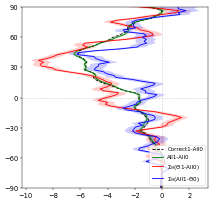

In [16]:
def zonal_mean_line_plot(variable='SWCF_d1',
                         lon_bounds=None,
                         scenario_source='All',
                         xlabel=None,
                         xlim=None,
                         ylabel=None,
                         title=None,
                         ax=None):
    # Create Axes if no Axes passed as an argument
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    # Scenario combinations etc to plot
    if scenario_source == 'All':
        scenario_combination_list = ['Correct1-All0', 'All1-All0',
                                     '$\Sigma_{\Theta}$($\Theta$1-All0)',
                                     '$\Sigma_{\Theta}$(All1-$\Theta$0)']
        color_list = ['k', 'g', 'r', 'b']
        linestyle_list = ['--', '-', '-', '-']
        shading_list = [False, True, True, True]
    else:
        scenario_combination_list = ['{}1-All0'.format(scenario_source),
                                     'All1-{}0'.format(scenario_source)]
        color_list = ['r', 'b']
        linestyle_list = ['-', '-']
        shading_list = [True, True]
    # Loop over scenario combinations
    for scenario_combination, c, linestyle, shading in zip(
            scenario_combination_list, color_list, linestyle_list, shading_list):
        # Load zonal statistics
        zonal_stats = lib_draft2017a.load_zonal_stats(
                scenario_combination=scenario_combination,
                variable=variable,
                lon_bounds=lon_bounds)
        mean = zonal_stats['mean']
        error = zonal_stats['error']
        # Legend label
        label = (scenario_combination)
        # Plot line
        ax.plot(mean, mean['lat'].data,
                c=c, linestyle=linestyle, alpha=1,
                label=label)
        # Plot shading
        if shading:
            ax.fill_betweenx(mean['lat'].data, mean-error, mean+error,
                             facecolor=c, alpha=0.2)
    # Lines showing zero
    ax.axhline(0, c='k', alpha=0.2, linewidth=1, linestyle='--')
    ax.axvline(0, c='k', alpha=0.2, linewidth=1, linestyle='--')
    # y-axis
    plt.yticks(fontsize='large')
    ax.set_ylim([-90, 90])
    ax.set_yticks(np.arange(-90, 91, 30))
    if ylabel:
        ax.set_ylabel(r'Latitude, $^\circ$N', fontsize='x-large')
    # x-axis
    plt.xticks(fontsize='large')
    if xlabel:
        ax.set_xlabel(xlabel, fontsize='x-large')
    if xlim:
        ax.set_xlim(xlim)
    # Title and legend
    if title:
        ax.set_title(title, fontsize='x-large')
    ax.legend(loc=4)
    return ax

# Example
if True:
    zonal_mean_line_plot()

## Function to produce map of differences

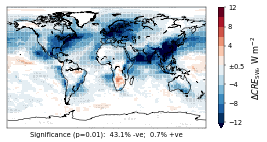

In [17]:
def difference_map(variable='SWCF_d1',
                   scenario_combination='All1-All0',
                   vlim=[-12, 12], whiteout='0.5',
                   cmap_name='RdBu_r', nlev=12, colorbar=True,
                   title=None,
                   ax=None):
    # Create Axes if no Axes passed as an argument
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    # Discretise colormap and set over/under
    cmap = plt.cm.get_cmap(cmap_name, nlev)
    if cmap_name == 'RdBu_r':
        cmap.set_under([0, 0, 0.25])
        cmap.set_over([0.25, 0, 0])
    elif cmap_name=='BrBG':
        cmap.set_under([0.2,0.1,0])
        cmap.set_over([0,0.15,0.1])
    # Load data for scenario combination
    stats_dict = lib_draft2017a.load_2d_stats(scenario_combination=scenario_combination,
                                              variable=variable)
    mean = stats_dict['mean']
    # Find where statistically significant
    if stats_dict['p_value'] is not None:  # use p-values if available
        sig_method = 'p=0.01'
        p_value = stats_dict['p_value']
        if np.isnan(p_value).any():  # check for NaNs and replace with ones...
            w_replace = (np.where(np.isnan(p_value) &
                                  (mean == 0.)))  #... if mean is zero
            p_value[w_replace] = 1.
        w_sig = np.where(p_value.ravel() <= 0.01)  # statistically significant at 0.01
        w_pos = np.where((p_value.ravel() <= 0.01) &  # significant and positive
                         (mean.values.ravel() > 0))
        w_neg = np.where((p_value.ravel() <= 0.01) &  # significant and negative
                         (mean.values.ravel() < 0))
    else:  # if p-values not available, use 99% confidence interval
        sig_method = '99% CI'
        ci99 = stats_dict['ci99']
        w_sig = np.where((ci99[0]*ci99[1]).values.ravel() > 0)  # 99% CI does not include zero
        w_pos = np.where(((ci99[0]*ci99[1]).values.ravel() > 0) &  # significant and positive
                         (mean.values.ravel() > 0))
        w_neg = np.where(((ci99[0]*ci99[1]).values.ravel() > 0) &  # significant and positive
                         (mean.values.ravel() < 0)) # negative
    lon_sig, lat_sig = np.meshgrid(mean['lon'].values, mean['lat'].values)
    lon_sig = lon_sig.ravel()[w_sig]
    lat_sig = lat_sig.ravel()[w_sig]
    # Map
    bm = Basemap(llcrnrlat=-90.0, urcrnrlat=90.0,
                 llcrnrlon=lon0, urcrnrlon=360.0+lon0, ax=ax)
    bm.drawcoastlines(ax=ax)
    # Plot field and stippling
    mean_masked = np.ma.masked_inside(mean, -1*float(whiteout), float(whiteout))
    im = ax.imshow(mean_masked,
                   extent=[lon0, 360+lon0, -lat0, lat0],
                   vmin=vlim[0], vmax=vlim[1], cmap=cmap, aspect='auto')
    ax.scatter(lon_sig, lat_sig, marker='.', s=0.05, c='k')
    # Colorbar
    if colorbar:
        if mean.min() < vlim[0] and mean.max() > vlim[1]:
            extend = 'both'
        elif mean.min() < vlim[0]:
            extend = 'min'
        elif mean.max() > vlim[1]:
            extend = 'max'
        else:
            extend = 'neither'
        ticks = np.arange(vlim[0], vlim[1]+1e-10, (vlim[1]-vlim[0])/(nlev/2))
        cbar = plt.colorbar(im, ticks=ticks, extend=extend)
        if float(whiteout) != 0:
            tick_labels = [item.get_text() for item in cbar.ax.get_yticklabels()]
            tick_labels[int(nlev/4)] = r'$\pm$' + whiteout
            cbar.ax.set_yticklabels(tick_labels, fontsize='large')
        label = '{}, {}'.format(variable_symbol_dict[variable],
                                variable_units_dict[variable])
        cbar.set_label(label, fontsize='x-large', labelpad=7)
    # Anotate with % significant and positive/negative
    n_boxes = mean['lon'].size * mean['lat'].size
    perc_pos = w_pos[0].size / n_boxes * 100
    perc_neg = w_neg[0].size / n_boxes * 100
    ax.text(0, -95,
            'Significance ({}):  {:.1f}% -ve;  {:.1f}% +ve'.format(sig_method, perc_neg, perc_pos),
            verticalalignment='top', horizontalalignment='center',
            fontsize='large')
    # Title
    if title:
        ax.set_title(title, fontsize='x-large')
    return ax, im, mean
                     
# Example
if True:
    difference_map()

## Function to produce map showing % contributions

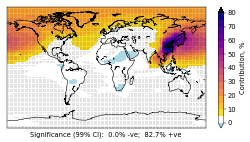

In [18]:
def contribution_map(variable='BURDENSO4',
                     scenario_combination='((EAs1-All0)+(All1-EAs0))/2',
                     ref_scenario_combination='All1',
                     vlim=[0, 80], nlev=16, cmap_name='plasma_r',
                     colorbar=True,
                     title=None,
                     ax=None):
    # Create Axes if no Axes passed as an argument
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    # Discretise colormap and set over/under etc
    cmap = plt.cm.get_cmap(cmap_name, nlev)
    if cmap_name == 'plasma_r':
        cmap.set_over('0.05')
        if vlim[0] == 0:
            cmap.colors[0] = np.array([1, 1, 1, 1])  # lowest segment to white
            cmap.set_under('lightblue')  # negative to blue
    # Load data for scenario combination
    stats_dict = lib_draft2017a.load_2d_stats(scenario_combination=scenario_combination,
                                              variable=variable)
    mean = stats_dict['mean']
    # Load data for reference scenario combination
    ref_stats_dict = lib_draft2017a.load_2d_stats(scenario_combination=ref_scenario_combination,
                                                  variable=variable)
    ref_mean = ref_stats_dict['mean']
    # % contribution
    contrib = mean / ref_mean * 100  # %
    # Standard error associated with % contribution
    error = np.abs(contrib) * np.sqrt((stats_dict['error']/mean)**2 +
                                      (ref_stats_dict['error']/ref_mean)**2)
    # Find where statistically significant using 99% confidence interval
    ci99 = (contrib - 2.576 * error, contrib + 2.576 * error)
    w_sig = np.where((ci99[0]*ci99[1]).values.ravel() > 0)  # 99% CI does not include zero
    w_pos = np.where(((ci99[0]*ci99[1]).values.ravel() > 0) &  # significant and positive
                     (contrib.values.ravel() > 0))
    w_neg = np.where(((ci99[0]*ci99[1]).values.ravel() > 0) &  # significant and negative
                     (contrib.values.ravel() < 0))
    lon_sig, lat_sig = np.meshgrid(mean['lon'].values, mean['lat'].values)
    lon_sig = lon_sig.ravel()[w_sig]
    lat_sig = lat_sig.ravel()[w_sig]
    # Map
    bm = Basemap(llcrnrlat=-90.0, urcrnrlat=90.0,
                 llcrnrlon=lon0, urcrnrlon=360.0+lon0, ax=ax)
    bm.drawcoastlines(ax=ax)
    # Plot field and stippling
    im = ax.imshow(contrib,
                   extent=[lon0, 360+lon0, -lat0, lat0],
                   vmin=vlim[0], vmax=vlim[1], cmap=cmap, aspect='auto')
    ax.scatter(lon_sig, lat_sig, marker='.', s=0.05, c='k')
    # Colorbar
    if colorbar:
        if contrib.min() < vlim[0] and contrib.max() > vlim[1]:
            extend = 'both'
        elif contrib.min() < vlim[0]:
            extend = 'min'
        elif contrib.max() > vlim[1]:
            extend = 'max'
        else:
            extend = 'neither'
        ticks = np.arange(vlim[0], vlim[1]+1e-10, (vlim[1]-vlim[0])/(nlev/2))
        cbar = plt.colorbar(im, ticks=ticks, extend=extend)
        cbar.ax.tick_params(labelsize='large') 
        label = 'Contribution, %'
        cbar.set_label(label, fontsize='large', labelpad=7)
    # Anotate with % significant and positive/negative
    n_boxes = mean['lon'].size * mean['lat'].size
    perc_pos = w_pos[0].size / n_boxes * 100
    perc_neg = w_neg[0].size / n_boxes * 100
    ax.text(0, -95,
            'Significance (99% CI):  {:.1f}% -ve;  {:.1f}% +ve'.format(perc_neg, perc_pos),
            verticalalignment='top', horizontalalignment='center',
            fontsize='large')
    # Title
    if title:
        ax.set_title(title, fontsize='x-large')
    return ax, im, mean
                     
# Example
if True:
    contribution_map()

## Results figures for main manuscript
Fig. 1, the map of the regions, is produced above.

Written local/f02.pdf
BURDENSO4 over globe:
  All1-Correct1 =  +0.00±0.01 (insignificant; p=0.765)


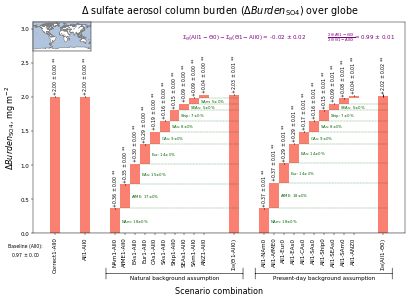

In [19]:
# Global sulfate aerosol burden
staggered_barcharts(variable='BURDENSO4', region='Globe',
                    text_format=r' {:+.2f} $\pm$ {:.2f} ',
                    ylim=[0, 3.1],
                    n_contributors='auto',
                    file_prefix='f{:02}'.format(figure_counter))
figure_counter += 1

In [20]:
# TODO: regional sulfate burdens
figure_counter += 1

Written local/f04.pdf
SWCF_d1 over globe:
  All1-Correct1 =  +0.01±0.02 (insignificant; p=0.576)


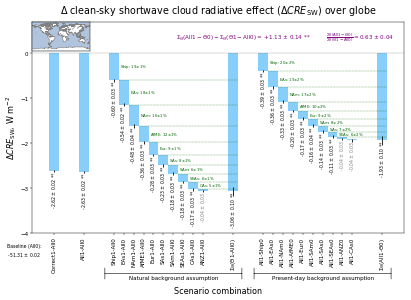

In [21]:
# Global SW CRE
staggered_barcharts(variable='SWCF_d1', region='Globe',
                    text_format=r' {:+.2f} $\pm$ {:.2f} ',
                    ylim=[-4, 0.7],
                    n_contributors='auto',
                    file_prefix='f{:02}'.format(figure_counter))
figure_counter += 1

In [22]:
# TODO: SW CRE zonal means, maps, and Hovmuller diagrams
figure_counter += 1

Written local/f06.pdf
LWCF over globe:
  All1-Correct1 =  +0.01±0.02 (insignificant; p=0.531)


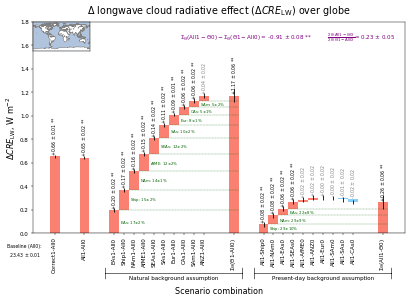

In [23]:
# Global LW CRE
staggered_barcharts(variable='LWCF', region='Globe',
                    text_format=r' {:+.2f} $\pm$ {:.2f} ',
                    ylim=[0, 1.8],
                    n_contributors='auto',
                    file_prefix='f{:02}'.format(figure_counter))
figure_counter += 1

In [24]:
# TODO: LW CRE zonal means, maps, and Hovmuller diagrams
figure_counter += 1

## Supplementary figures
Figs. S1-S3 are produced in the Emissions section above.

In [25]:
# Global organic carbon aerosol burden - supp figure
if produce_supp:
    staggered_barcharts(variable='BURDENPOM', region='Globe',
                        text_format=r' {:+.3f} $\pm$ {:.3f} ',
                        ylim=[0, 0.52],
                        n_contributors='auto',
                        file_prefix='fS{:02}'.format(supp_figure_counter))
    supp_figure_counter += 1

In [26]:
# TODO: regional OC burdens
if produce_supp:
    supp_figure_counter += 1

In [27]:
# Global black carbon aerosol burden - supp figure
if produce_supp:
    staggered_barcharts(variable='BURDENBC', region='Globe',
                        text_format=r' {:+.4f} $\pm$ {:.4f} ',
                        ylim=[0, 0.15],
                        n_contributors='auto',
                        file_prefix='fS{:02}'.format(supp_figure_counter))
    supp_figure_counter += 1

In [28]:
# TODO: regional BC burdens
if produce_supp:
    supp_figure_counter += 1

In [29]:
# Global liquid water path - supp figure
if produce_supp:
    staggered_barcharts(variable='TGCLDLWP', region='Globe',
                        text_format=r' {:+.2f} $\pm$ {:.2f} ',
                        ylim=[0, 7.5],
                        n_contributors='auto',
                        file_prefix='fS{:02}'.format(supp_figure_counter))
    supp_figure_counter += 1

In [30]:
# TODO: LWP zonal means, maps, and Hovmuller diagrams
if produce_supp:
    supp_figure_counter += 1

In [31]:
# Global ice water path - supp figure
if produce_supp:
    staggered_barcharts(variable='TGCLDIWP', region='Globe',
                        text_format=r' {:+.3f} $\pm$ {:.3f} ',
                        ylim=[-0.1, 1.15],
                        n_contributors='auto',
                        file_prefix='fS{:02}'.format(supp_figure_counter))
    supp_figure_counter += 1

In [32]:
# TODO: IWP zonal means, maps, and Hovmuller diagrams
if produce_supp:
    supp_figure_counter += 1

Some additional supplementary figures are produced by [emissions_bug_draft2017a.ipynb](https://github.com/grandey/draft2017a-region-rfp/blob/master/emissions_bug_draft2017a.ipynb).

## Other figures - not included in manuscript or supplement

In [33]:
# Global AOD - other figure
if produce_other:
    staggered_barcharts(variable='AEROD_v', region='Globe',
                        text_format=r' {:+.4f} $\pm$ {:.4f} ',
                        ylim=[0, 0.024],
                        n_contributors='auto',
                        file_prefix='fZ{:02}'.format(other_figure_counter))
    other_figure_counter += 1

In [34]:
# Global DRE - other figure
if produce_other:
    staggered_barcharts(variable='FSNTOA-FSNTOA_d1', region='Globe',
                        text_format=r' {:+.4f} $\pm$ {:.4f} ',
                        ylim=[-0.06, 0.13],
                        n_contributors='auto',
                        file_prefix='fZ{:02}'.format(other_figure_counter))
    other_figure_counter += 1

In [35]:
# Global SRE - other figure
if produce_other:
    staggered_barcharts(variable='FSNTOAC_d1', region='Globe',
                        text_format=r' {:+.4f} $\pm$ {:.4f} ',
                        ylim=[-0.29, 0.06],
                        n_contributors=0,
                        file_prefix='fZ{:02}'.format(other_figure_counter))
    other_figure_counter += 1

In [36]:
# Global net ERF - other figure
if produce_other:
    staggered_barcharts(variable='FSNTOA+LWCF', region='Globe',
                        text_format=r' {:+.2f} $\pm$ {:.2f} ',
                        ylim=[-2.6, 0.45],
                        n_contributors='auto',
                        file_prefix='fZ{:02}'.format(other_figure_counter))
    other_figure_counter += 1

In [37]:
# Sulfate burdens, SW CRE, LW CRE, and Net ERF for different regions - other figures
if produce_other:
    for region, ylims, in {'EAs': ([0, 7.9], [-11.5, 2.3], [0, 4], [-8, 1.6]),
                           'NAm': ([0, 4.7], [-6.7, 1.2], [0, 1.6], [-5.6, 1.1]),
                           'Eur': ([0, 7.7], [-10.4, 2.2], [0, 2.8], [-8.2, 1.7]),
                           'AfME': ([0, 5.9], [-7.3, 1.6], [-0.6, 3.4], [-3.5, 0.8]),
                           'CAs': ([0, 8.3], [-7.1, 1.6], [-1.0, 2.6], [-6.5, 1.4]),
                           'SAs': ([0, 8], [-15.5, 3.2], [0, 11], [-5.6, 1.2]),
                           'SEAs': ([0, 2], [-6, 1.0], [0, 3.2], [-3, 0.5]),
                           'SAm': ([0, 1.6], [-2.8, 0.6], [-0.65, 0.4], [-2.6, 0.6]),
                           'ANZ': ([0, 1.3], [-3, 2], [-0.5, 1.2], [-1.9, 0.7])
                         }.items():
        staggered_barcharts(variable='BURDENSO4', region=region,
                            text_format=r' {:+.2f} $\pm$ {:.2f} ',
                            ylim=ylims[0],
                            n_contributors='auto',
                            file_prefix='fZ{:02}'.format(other_figure_counter))
        other_figure_counter += 1
        staggered_barcharts(variable='SWCF_d1', region=region,
                            text_format=r' {:+.2f} $\pm$ {:.2f} ',
                            ylim=ylims[1],
                            n_contributors='auto',
                            file_prefix='fZ{:02}'.format(other_figure_counter))
        other_figure_counter += 1
        staggered_barcharts(variable='LWCF', region=region,
                            text_format=r' {:+.2f} $\pm$ {:.2f} ',
                            ylim=ylims[2],
                            n_contributors='auto',
                            file_prefix='fZ{:02}'.format(other_figure_counter))
        other_figure_counter += 1
        staggered_barcharts(variable='FSNTOA+LWCF', region=region,
                            text_format=r' {:+.2f} $\pm$ {:.2f} ',
                            ylim=ylims[3],
                            n_contributors='auto',
                            file_prefix='fZ{:02}'.format(other_figure_counter))
        other_figure_counter += 1

In [38]:
! date

Mon Apr 30 12:14:00 +08 2018
